<a href="https://colab.research.google.com/github/LucaM185/textUpscaler/blob/main/neural_upscaler_for_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pickle


try: 
  device = torch.device("cuda:0") 
  print("CUDA")
except:
  device = torch.device("cpu")

CUDA


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cap = cv2.VideoCapture('drive/MyDrive/VideoMasterplan.mp4')

frames = []
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        # convert the frame to a tensor
        frames.append(torch.from_numpy(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)))
    else:
        break

images = torch.stack(frames)

cap.release()

In [ ]:
images.shape

torch.Size([405, 1920, 1080])

In [ ]:
# Define width, height, and overlap size
width = 100
height = 100
overlap = 40

# Calculate the number of patches per dimension
num_patches_w = (1920 - overlap) // (width - overlap)
num_patches_h = (1080 - overlap) // (height - overlap)

# Reshape tensor into patches
patches = images[:100].unfold(1, width, width - overlap).unfold(2, height, height - overlap)

# Reshape patches into a 2D tensor of shape (-1, width * height)
patches = patches.reshape(-1, width * height)

# Get the number of patches
num_patches = patches.shape[0]

# Reshape patches back into a 3D tensor of shape (-1, width, height)
patches = patches.reshape(-1, width, height)

# Print the shape of the patches tensor
print(patches.shape)


torch.Size([52700, 100, 100])


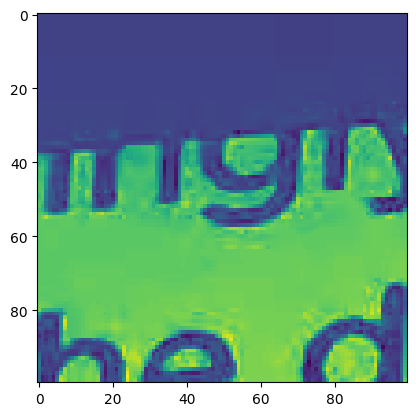

In [ ]:
plt.imshow(patches[14])

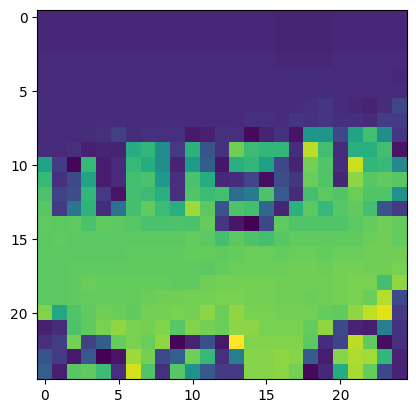

In [ ]:
plt.imshow(patches[14, ::4, ::4])

In [ ]:
class NeuralUpscaler(nn.Module):
    def __init__(self):
        super(NeuralUpscaler, self).__init__()

        # Define the convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )

        # Define the upsampling layers
        self.upsample_layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x):
        # Pass the input through the convolutional layers
        x = self.conv_layers(x)

        # Upsample the output of the convolutional layers
        x = self.upsample_layers(x)

        # Return the upscaled image
        return x

In [ ]:
inputImages, upscaledImages = patches[:, ::4, ::4].float(), patches.float()

# Initialize the neural upscaler and the optimizer
net = NeuralUpscaler().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Define the loss function
criterion = nn.MSELoss()

# Define the batch size
batch_size = 128

# Define the number of epochs
num_epochs = 10

# Loop over the epochs
for epoch in range(num_epochs):
    # Shuffle the indices of the input and upscaled images
    indices = torch.randperm(inputImages.shape[0])
    
    # Loop over the batches
    for batch_idx in range(0, inputImages.shape[0]-batch_size, batch_size):
        # Select the batch indices
        batch_indices = indices[batch_idx:batch_idx+batch_size]
        
        # Select the input and upscaled images for the batch
        batch_input = inputImages[batch_indices].view(batch_size, 1, inputImages.shape[1], inputImages.shape[2]).to(device)
        batch_upscaled = upscaledImages[batch_indices].view(batch_size, 1, upscaledImages.shape[1], upscaledImages.shape[2]).to(device)
        
        # Zero the gradients of the optimizer
        optimizer.zero_grad()

        # Pass the input through the neural upscaler to generate the predicted images
        batch_predicted = net(batch_input)
        
        # Compute the loss between the predicted and upscaled images
        loss = criterion(batch_predicted, batch_upscaled)
        
        # Backpropagate the loss through the neural upscaler
        loss.backward()
        
        # Update the parameters of the neural upscaler using the optimizer
        optimizer.step()
    # Print the loss after each epoch
    print('Epoch {}/{} - Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


Epoch 1/10 - Loss: 156.4527
Epoch 2/10 - Loss: 124.6326
Epoch 3/10 - Loss: 98.1917
Epoch 4/10 - Loss: 87.4849
Epoch 5/10 - Loss: 96.3173
Epoch 6/10 - Loss: 106.0172
Epoch 7/10 - Loss: 95.5247
Epoch 8/10 - Loss: 76.2901
Epoch 9/10 - Loss: 112.8860
Epoch 10/10 - Loss: 55.1096


In [ ]:
# Save the model using pickle
#with open('net.pkl', 'wb') as f:
#    pickle.dump(net, f)


In [ ]:
with open('net.pkl', 'rb') as f:
    net = pickle.load(f)

In [ ]:
testpatches = images[100:105].unfold(1, width, width - overlap).unfold(2, height, height - overlap)

# Reshape patches into a 2D tensor of shape (-1, width * height)
testpatches = testpatches.reshape(-1, width * height)

# Get the number of patches
testnum_patches = testpatches.shape[0]

# Reshape patches back into a 3D tensor of shape (-1, width, height)
testpatches = testpatches.reshape(-1, width, height)

# Print the shape of the patches tensor
print(testpatches.shape)


torch.Size([2635, 100, 100])


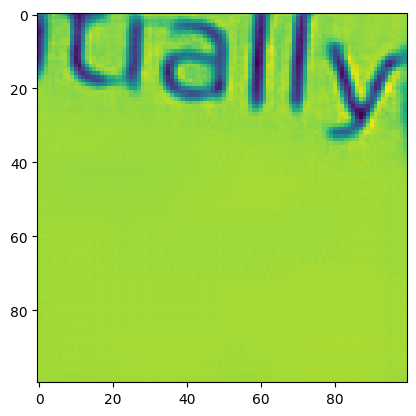

In [ ]:
downscaled = testpatches[173, ::4, ::4].view(1, 1, 25, 25).float().to(device)
upscaled = net(downscaled).cpu().detach().numpy()[0][0]
plt.imshow(upscaled)

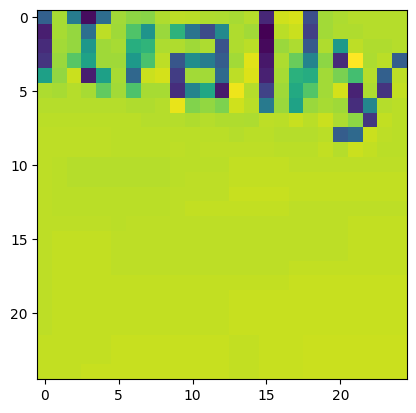

In [ ]:
plt.imshow(testpatches[173, ::4, ::4])

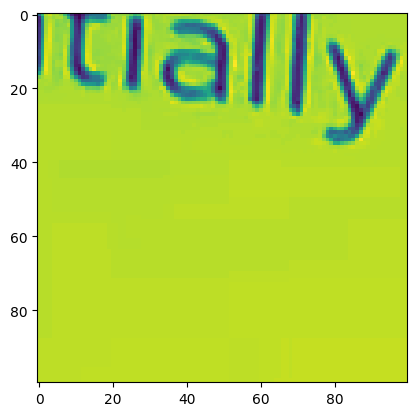

In [ ]:
plt.imshow(testpatches[173])

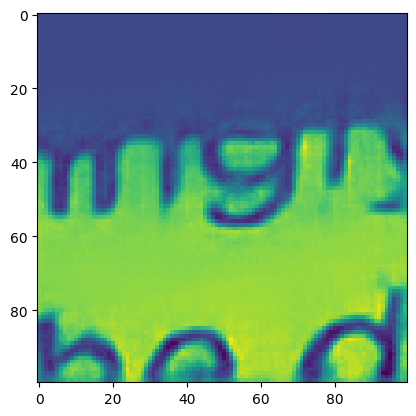

In [ ]:
downscaled = patches[14, ::4, ::4].view(1, 1, 25, 25).float().to(device)
upscaled = net(downscaled).cpu().detach().numpy()[0][0]
plt.imshow(upscaled)